# WeatherPy

SEE OBSERVATIONS AND COMMENTS BELOW EACH GRAPH


In [37]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

#Set todays date to include in plots
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")


## Generate Cities List and dataframe

- Generate 1500 random latitude and longitude pairs
- Use citypy to find the cities nearest those lat/long coordinates. Note this may result in the same city being nearest to more than one of the lat/long coords. In this case the city is ignored. So the final list of cities may be fewerr than the number of random lat/long coords generated.
- Output is a list of cities with their country and the lat/long coords that produced that city from citipy. Note that these lat/long coords are not the actual lat/long coords of the city on a map. These will be found from the OpenWeather API in the nest step.

In [38]:
#Initialize empty lists for: Lat/Lng pairs, cities, countries, latitude, and longitude (the original pairs used to find the "nearest city"). Note this is NOT the actual lat/lng of the city, this is captured later from the OpenWeather API

#Reinitialize lists to null
cities = []
countries=[]
orig_latitude=[]
orig_longitude=[]
city_ID=[]
city_temp=[]
city_humidity=[]
city_clouds_pct=[]
city_windspeed=[]
city_latitude=[]
city_longitude=[]

#How many cities do you want to plot?
target_city_count = 501

#Set counter to test if we have found the requested number of cities that are in citypy, OpenWeather, and with humidity<=100. This ensures the final city list will meet the target number precisely.
big_city_count = 0
while big_city_count<target_city_count:
    #Get a random lat long coordinate
    lats = np.random.uniform(lat_range[0], lat_range[1])
    lngs = np.random.uniform(lng_range[0], lng_range[1])
    #Get the nearest city and it's country from citipy
    city = citipy.nearest_city(lats, lngs).city_name
    country = citipy.nearest_city(lats, lngs).country_code
    #Create the OpenWeather url using the city and country from citypy and my personal weather api key
    url = 'http://api.openweathermap.org/data/2.5/weather?q='+city+',,'+country+'&units=imperial&appid='+weather_api_key
    #Get the response from OpenWeather API
    res = requests.get(url)
    #If response is 200 then OpenWeather has data on this city so proceed to read json data add the city to the df
    if res.status_code == 200:
        response = res.json()
        #Check for humidity not over 100 as per instructions
        if response['main']['humidity']<=100:
            #Print the city ID and name as they are being processed to show progress
            cityid=response['id']
            print(f'{cityid} {city}')
            #Append all the necessary data to lists
            cities.append(city)
            countries.append(country)
            orig_latitude.append(lats)
            orig_longitude.append(lngs)
            city_ID.append(response['id'])
            city_temp.append(response['main']['temp'])
            city_humidity.append(response['main']['humidity'])
            city_clouds_pct.append(response['clouds']['all'])
            city_windspeed.append(response['wind']['speed'])
            city_latitude.append(response['coord']['lat'])
            city_longitude.append(response['coord']['lon'])
            big_city_count += 1

#Create the city df that has the exact number of desired cities with no city with humidity >100
city_data = pd.DataFrame(columns=['City ID', 'City', 'Country', 'Orig Lat', 'Orig Lon', 'Act Lat', 'Act Lon', 'Temperature (F)', 'Humidity', 'Cloudiness', 'Wind Speed'])

#Add the lists from the loops to the df
city_data['City ID'] = city_ID
city_data['City'] = cities
city_data['Country'] = countries
city_data['Orig Lat'] = orig_latitude
city_data['Orig Lon'] = orig_longitude
city_data['Act Lat'] = city_latitude
city_data['Act Lon'] = city_longitude
city_data['Temperature (F)'] = city_temp
city_data['Humidity'] = city_humidity
city_data['Cloudiness'] = city_clouds_pct
city_data['Wind Speed'] = city_windspeed

#Set df index to the unique city ID from OpenWeather API
city_data.set_index('City ID', inplace=True)

#Clean up by deleting columns not needed for plot. Delete the original lat and long since they are not the actual lat and long of the city itself.
del city_data['Orig Lat']
del city_data['Orig Lon']

#Create the northern and southern hemisphere splits of the city df
north_city_data = city_data.loc[city_data['Act Lat']>=0]
south_city_data = city_data.loc[city_data['Act Lat']<0]

#Control check output
print('The total number of cities added is '+str(len(city_data)))

#Export the City_Data and Clean_city_data into csv's
city_data.to_csv(output_data_file)


3472473 alto araguaia
3369157 cape town
3424934 saint-pierre
162158 baherden
4030556 rikitea
2206939 bluff
3804949 guasdualito
3366880 hermanus
4030556 rikitea
4030556 rikitea
1649150 bengkulu
964432 port alfred
3939168 huarmey
3372707 ribeira grande
5882953 aklavik
1788852 xining
5563839 fortuna
2180815 tuatapere
3663475 maraa
2162737 ingham
923058 kambove
2155415 new norfolk
3386213 touros
3833367 ushuaia
3573061 saint george
2618795 klaksvik
6540785 castrovillari
3855065 general roca
935215 saint-philippe
3370903 jamestown
3833367 ushuaia
3874787 punta arenas
551124 kemlya
2163355 hobart
4030556 rikitea
1489508 toguchin
3430443 necochea
1106643 quatre cocos
1015776 bredasdorp
2163355 hobart
1282256 hithadhoo
4449620 vicksburg
1244926 hambantota
5282297 bethel
4036284 alofi
2163355 hobart
3833367 ushuaia
3896218 castro
3833367 ushuaia
3833367 ushuaia
4030556 rikitea
2121385 severo-kurilsk
2155415 new norfolk
5866583 kodiak
3652764 puerto ayora
5848280 kapaa
2075265 busselton
1267369 

## Plotting the Data and Linear Regression
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

##Function to return scatter plot and optional linear regression plat and file path/name for saving

In [39]:
#A function which takes in: 1) x data, 2) y data, 3) name for x axis, 4) name for y axis, 5) indicate or whether to draw linear regression or not: TRUE = include linear regression plot, FALSE = do not include linear regression.abs

def get_line(x,y,x_name,y_name, incl_regress):
    #Initialize the two plats: ax1=scatter, ax2=linear regression line    
    ax1=[]
    ax2=[]
    #count the number of cities in the plot to include in the title
    city_count = x.count()
    #Do scatter plot, titel, and labels
    ax1=plt.scatter(x,y)
    ax1=plt.title(f'{city_count} cities on {timestampStr}: {y_name} vs. {x_name}')
    ax1=plt.xlabel(x_name)
    ax1=plt.ylabel(f'{y_name}')
    #Include linear regression plot if flag indicates 
    if incl_regress:
        #Perform linear regression and r2 and plot
        slope, intercept, rvalue, pvalue, stderr = st.linregress(x,y)
        r_squared = rvalue**2
        ax2=plt.plot(x, x*slope+intercept, color='red', label= 'Y= '+str(round(slope,2))+'*X + '+str(round(intercept,2))+' R2='+str(round(r_squared,2)))
        #Use legend to show the linear regression equation and R2 value
        ax2=plt.legend()
    #Determine if plot is Global, Southern, or Northern hemisphere to include in file name
    if min(x)<0:
        if max(x)>0:
            hem='Global'
            ax1 = plt.xlim(-60, 90)
        else:
            hem='South'
            ax1 = plt.xlim(-60, 0)
    else:
        hem='North'
        ax = plt.xlim(0,90)
    
    #Define output png name
    png_file = 'output_data/'+y_name+'_'+x_name+'_'+hem+'.png'

    #retrun the two plots and the png file name
    return ax1, ax2, png_file

## Latitude vs. Temperature Plot

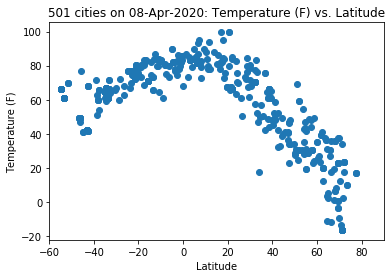

In [40]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', False)
plt.savefig(png_file)
plt.show()

OBSERVATION TEMPERATURE VS. LATITUDE
- A blind linear regression would indicate a weak-to-medium relationship between temperature and latitude. However, visual inspection and common sense indicat that there is clearly a relationship of some sort with an inflection point near 0 degrees latitude. Therefore the data should be evaluated separately for each latitude.
- There are little to no cities in the Southern Hemisphere below -60 degrees latitude, therefore the x axis was limited to improve readability.
- The change in temp per change in lat (slope) appers higher in the north than the south.

## Latitude vs. Humidity Plot

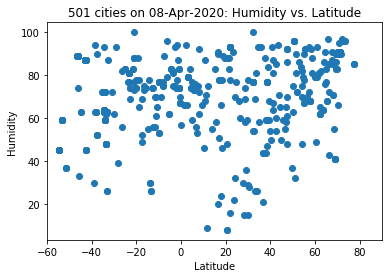

In [41]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Humidity'], 'Latitude', 'Humidity', False)
plt.savefig(png_file)
plt.show()

OBSERVATION HUMIDITY VS. LATITUDE
- There is no apparent relationship between humidity and latitude.
- Most cities tend to have humidity levels above about 50%

## Latitude vs. Cloudiness Plot

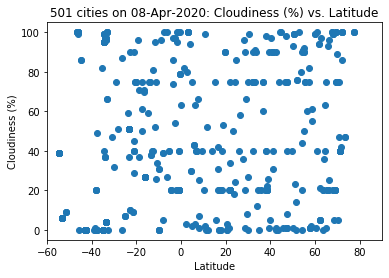

In [42]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', False)
plt.savefig(png_file)
plt.show()

OBSERVATIONS CLOUDINESS VS. LATITUDE
- There is no apparent relationship between cloudiness and latitude.
- Cloudiness appears to be bunched at multiple of 20% (20%, 40%, etc). This is likely due to the reporting framework and how cloudiness is measured.

## Latitude vs. Wind Speed Plot

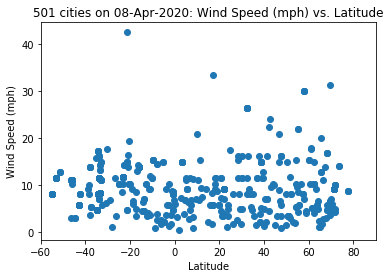

In [43]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Wind Speed'], 'Latitude', 'Wind Speed (mph)', False)
plt.savefig(png_file)
plt.show()

OBSERVATIONS WIND SPEED VS. LATITUDE
- There is no apparent relationship between wind speed and latitude.
- Wind speeds tend to occur between 0 and 18 mph

## Northern Hemisphere - Latitude vs. Temperature Plot 

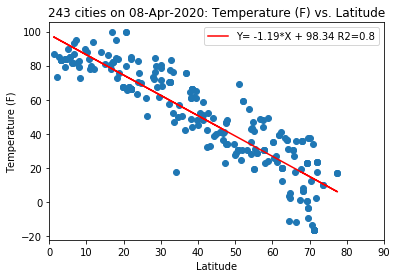

In [44]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

OBSERVATIONS TEMPERATURE VS. LATITUDE IN THE NORTHERN HEMISPHERE
- There is a strong linear relationship between temperature and latitude indicated by r-squared of 0.8.

## Southern Hemisphere - Latitude vs. Temperature Plot 

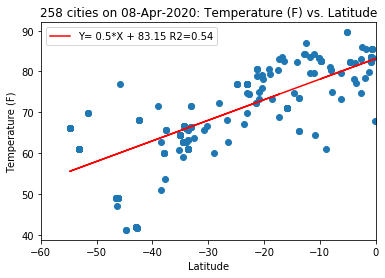

In [45]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

OBSERVATIONS TEMPERATURE VS. LATITUDE IN THE SOUTHERN HEMISPHERE
- There is a reasonably strong lineary relationship between temperature and latitude indicated by r-squared of 0.54.
- The r-squared is less than the northern hemispher. Likely due the lesser spread of data points due to the fact there are fewer cities at the more extreme latitudes in the southern hemisphere.
- The slope of the line is less than that in the northern hemispher, meaning the drop in temperature is less dramatic as latitude increases.
- The intercept of 84.44F indicates the estimated temperature at the equator. Interestingly this is materially different than the intercept of the northern hemisphere linear regression of 100.75F

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

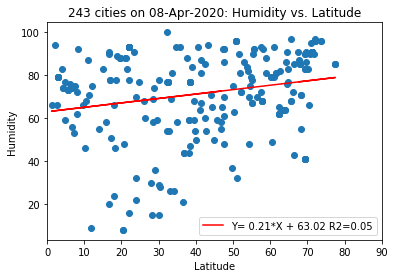

In [46]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

OBSERVATION HUMIDITY VS LATITUDE IN THE NORTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.04
- There appears to be less variability in humidity levels ('bunching') at latitudes 50-80.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

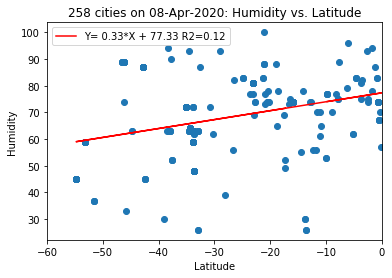

In [47]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

OBSERVATION HUMIDITY VS LATITUDE IN THE SOUTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.05
- There appears to be less variability in humidity levels ('bunching') at latitudes 50-80.
- Again, the estimate of humidity at the equator as indicated by the intercepts is materially different based on northern vs southern data.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

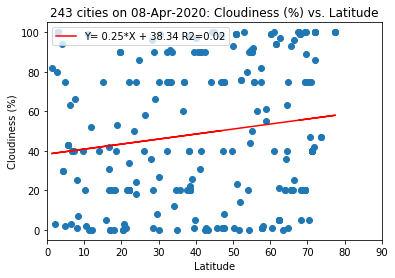

In [48]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

OBSERVATION CLOUDINESS VS LATITUDE IN THE NORTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.0
- Banding of reported values due to the reporting mechanism is apparent

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

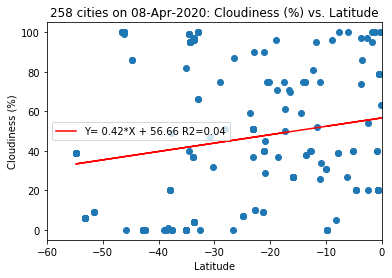

In [49]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

OBSERVATION CLOUDINESS VS LATITUDE IN THE NORTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.0
- Banding is less apparent in the southern data, possibly due to the lesser spread of latitude values in the data.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

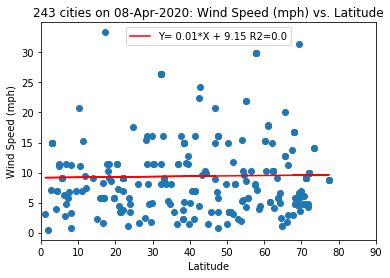

In [50]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Wind Speed'], 'Latitude', 'Wind Speed (mph)', True)
plt.savefig(png_file)
plt.show()

OBSERVATION WIND SPEED VS LATITUDE IN THE NORTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.0
- Typical wind speeds tend to occur between 0-15 mph.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

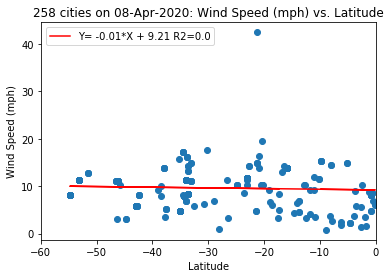

In [51]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Wind Speed'], 'Latitude', 'Wind Speed (mph)', True)
plt.savefig(png_file)
plt.show()

OBSERVATION WIND SPEED VS LATITUDE IN THE SOUTHERN HEMISPHERE
- There is no apparent linear relationship as indicated by a low r-squared of 0.05
- Typical wind speeds tend to occur between 0-15 mph.